# Golden-Search Method for Gradient Descent's Step Size

While searching for ways to choose an "optimal" step-size for gradient descent's optimization method, I stumbled upon several convex optimization techniques used for this. But the main idea was simply to find the right step-size $\eta^*$ of each iteration of the algorithm. To achieve this, we need to start implementing gradient descent in the original way, updating the parameters in the direction of steepest descent. The following algorithm is able to do that.

* initialize $\mathbf{\theta}$ as a random vector
* while $||\mathbf{\theta}^{k} - \mathbf{\theta}^{k-1}||$ > treshold:
    * update parameter $ \mathbf{\theta}^{k} = \mathbf{\theta}^{k-1} - \eta\nabla_\mathbf{\theta} f(\mathbf{\theta}^{k-1}) $ 
    
Lets program our gradient descent algorithm with a fixed step size:

## Gradient Descent - Fixed Step Size

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

%matplotlib notebook

In [2]:
def fixed_step_GD(cost_function, gradient_func, point, 
                  max_iter = 100000, tresh = 0.0000001, step_size=0.0001):
    counter = 0
    list_coef = [point]
    prev_point = point
    while counter < max_iter:
        gradient = gradient_func(point)
        point = point - step_size * gradient
        counter = counter + 1
        if np.linalg.norm(prev_point-point) < tresh:
            break
        list_coef.append(point)
        prev_point = point
    print("steps: " + str(counter))
    list_coef = np.array(list_coef)
    return point, list_coef

This function is going to accept a two functions as parameters `cost_function` which is the function to minimize and `gradient_func` which is the derivative of this function. It also takes an arbitrary random `point` (which in this case is $\mathbf{\theta}$) to initialize the algorithm.


Now lets declare our function to minimize. We will minimize the function of the regularized linear regression with respect to $\theta$, which has the form:

$$ J(\mathbf{X}, \mathbf{Y}, \mathbf{\theta}) = (\mathbf{Y - X\theta})'(\mathbf{Y - X\theta}) + \frac{\lambda}{2}\mathbf{\theta'\theta}$$

and with gradient


$$ \nabla_{\theta}J(\mathbf{X}, \mathbf{Y}, \mathbf{\theta}) = -2 \mathbf{X'Y} + 2 \mathbf{X'X \theta} + \lambda \theta$$

In [3]:
def cost_function(p): return np.dot((Y - np.matmul(X, p).reshape(Y.shape)).T, 
                                    (Y - np.matmul(X, p).reshape(Y.shape))) + reg / 2.0 * np.dot(p.T, p)
def gradient_func(p): return -2 * np.matmul(X.T, Y) + 2 * np.matmul(np.matmul(X.T, X), p) + reg * p

To test this we will need to have a data set $\mathbf{X}$ (Augmented) with labels $\mathbf{Y}$, we will generate this with the use of `numpy.random.multivariate_normal`

<IPython.core.display.Javascript object>


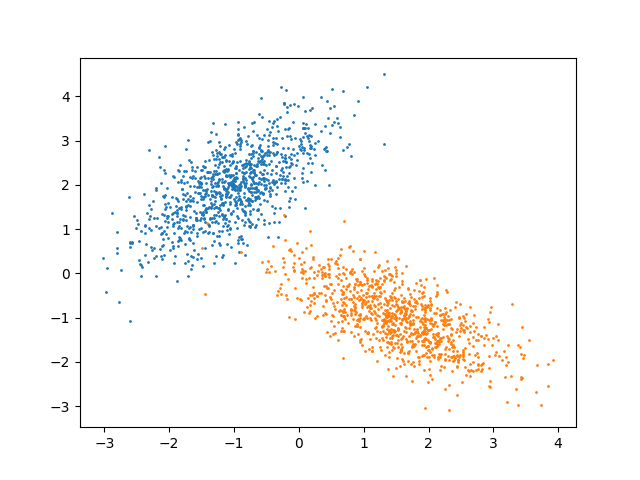

In [4]:
plt.figure()
std = [[0.5, 0.4], [0.4,0.7]]
std2 = [[0.7, -0.4], [-0.4,0.5]]
c1 = np.random.multivariate_normal([-1, 2], std, 1000);
c2 = np.random.multivariate_normal([1.5, -1], std2, 1000);
X = np.concatenate([c1,c2])

#Vector augmentation [1 X]
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

labels = np.ones(1000)
labels2 = -1 * np.ones(1000)
Y = np.concatenate([labels, labels2])
Y = Y.reshape((Y.shape[0], 1))

plt.scatter(c1[:,0], c1[:,1], s=1)
plt.scatter(c2[:,0], c2[:,1], s=1)
plt.show()

Now we can start optimizing the function by initializing the $\theta$ parameters with random number using `np.random.randn` and then running the gradient descent function. 

steps: 725
Execution time: 0.04133009910583496


<IPython.core.display.Javascript object>


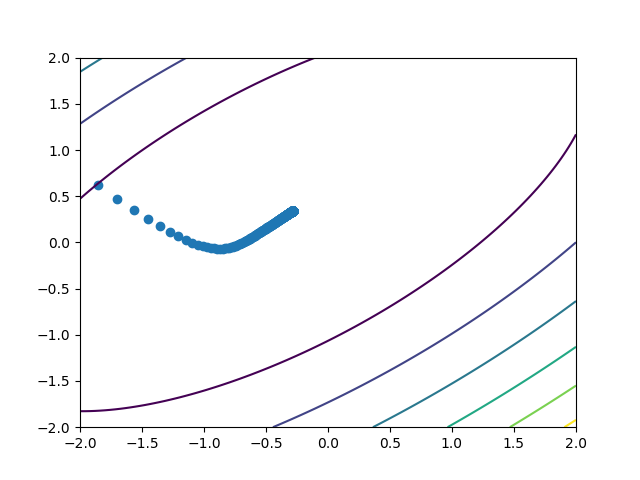

In [5]:
np.random.seed(17)
point = np.random.randn(X.shape[1], 1)
reg = 0.01 #Regularization parameter

start = time.time()
sol, list_coef = fixed_step_GD(cost_function, gradient_func, point, step_size = 0.00001)
end = time.time()
print("Execution time: " + str(end-start))

plt.figure()
plt.scatter(list_coef[:,1], list_coef[:,2])

row = np.linspace(-2, 2, 100)
Xmesh,Ymesh = np.meshgrid(row,row)
Z = np.zeros(Xmesh.shape)
for i in range(Xmesh.shape[0]):
    for j in range(Xmesh.shape[1]):
        point_k = np.array([[0], [Xmesh[i,j]], [Ymesh[i,j]]])
        Z[i,j] = cost_function(point_k)
        
plt.contour(Xmesh,Ymesh,Z)
plt.show()

Notice that the step_size is `step_size=0.0001`, this is giving us corvengeance in this situation but if we use `step_size=0.001` it will diverge and we will not find a solution.

## Golden-Search to find step size


Now we are going to implement the gradient descent method with the golden-search algorithm to find the "optimal step size", This is done by evaluating our function in the "new parameter" and minimizing this function with respect to the step size $\eta$

$$ \eta^* = \displaystyle\min_\eta f(\eta) = \displaystyle\min_\eta f(\mathbf{\theta}^{i-1} - \eta\mathbf{u}^{i-1})  $$

where $\mathbf{u}$ is the gradient of the function $f(.)$ with respect to the vector $\mathbf{\theta}$

$$ \mathbf{u} = \nabla_\mathbf{\theta} f(\mathbf{\theta}) $$

This seems a little bit confusing but it is just trying to find the right `step_size` at each step of the gradient descent. 


Now lets use our gradient descent with the golden search method. First, lets write a program which does line-search using the golden ratio

In [6]:
def goldenSearch(function, a=0, b=3, tresh=0.000001):
    golden_ratio = 0.618034

    # Define initial length for search
    length = b - a

    lambda_1 = a + golden_ratio ** 2 * length
    lambda_2 = a + golden_ratio * length

    while length > tresh:

        if function(lambda_1) > function(lambda_2):
            a = lambda_1
            lambda_1 = lambda_2
            length = b - a
            lambda_2 = a + golden_ratio * length
        else:
            b = lambda_2
            lambda_2 = lambda_1
            length = b - a
            lambda_1 = a + golden_ratio ** 2 * length

    return (b + a) / 2.0

Remember that we need to minimize a new function. Instead of minimizing 
$$ \displaystyle\min_{\theta} J(\mathbf{X,Y,\theta})$$ we are going to minimize the following function, having $\mathbf{X}$ and $\mathbf{Y}$ fixed
$$ \displaystyle\min_{\eta} J( \theta^{k-1} - \eta\nabla_\theta J(\theta^{k-1}))$$

Now we need use the goldenSearch function to find $\eta$ in each step of the gradient descent, lets program a new gradient descent function with this golden-search method.

In [7]:
def goldenStep(function, gradient, point):
    def optimizer(s): return function(point - s * gradient(point))

    return goldenSearch(optimizer)

def goldenDescent(cost_function, gradient_func, point, 
                  max_iter = 100000, tresh = 0.0000001, step_size=0.0001):
    counter = 0
    list_coef = [point]
    prev_point = point
    while counter < max_iter:
        gradient = gradient_func(point)
        step = goldenStep(cost_function, gradient_func, point)
        point = point - step * gradient
        counter = counter + 1
        if np.linalg.norm(prev_point-point) < tresh:
            break
        list_coef.append(point)
        prev_point = point
    print("steps: " + str(counter))
    list_coef = np.array(list_coef)
    return point, list_coef

Plotting solution steps, we see that the solution converges way faster than in the last algorithm, doing a zig-zag movement through the function. Unfortunately the cost of using the `goldenSearch` method is way to big and the overall time of execution of the program increases.

steps: 78
Execution time: 0.2488846778869629


<IPython.core.display.Javascript object>


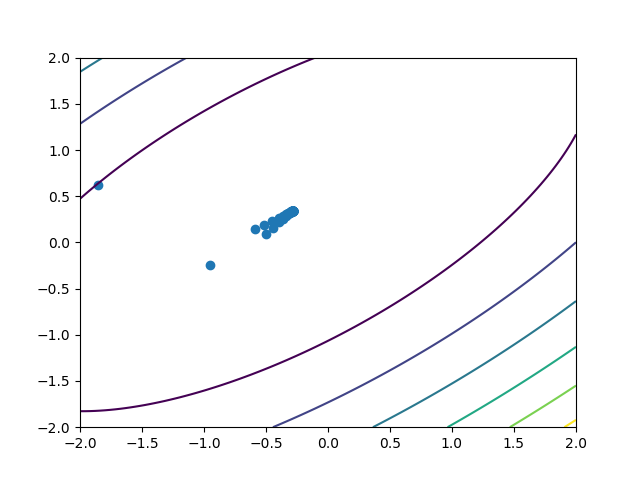

In [8]:
np.random.seed(17)
point = np.random.randn(X.shape[1], 1)

start = time.time()
sol, list_coef = goldenDescent(cost_function, gradient_func, point)
end = time.time()
print("Execution time: " + str(end-start))

plt.figure()
plt.scatter(list_coef[:,1], list_coef[:,2])

Xmesh,Ymesh = np.meshgrid(row,row)
Z = np.zeros(Xmesh.shape)
for i in range(Xmesh.shape[0]):
    for j in range(Xmesh.shape[1]):
        point_k = np.array([[0], [Xmesh[i,j]], [Ymesh[i,j]]])
        Z[i,j] = cost_function(point_k)
        
plt.contour(Xmesh,Ymesh,Z)
plt.show()

This is way slower than the gradient descent with fixed step size, but this method gives us a way to guarantee convergeance without worrying if we chose a good step size. It is theoretically elegant but unfortunately way to expensive to implement in practice. 